In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.linalg import logm, expm

In [2]:
#Define known quantities
f_sam = 65536 #Hz
dt = 1/f_sam #sampling interval
k_B = 1.38064881313131e-23  # Boltzmann constant (Newton metre/Kelvin)
T = 275 #Kelvin
beta = 1/(k_B*T)
N = 65536 #Number of data points

In [3]:
#Load position velocity data
x = np.fromfile('position.txt',dtype=float,count=-1,sep = " ").reshape(N,1)
v = np.fromfile('velocity.txt',dtype = float, count=-1, sep = " ").reshape(N,1)

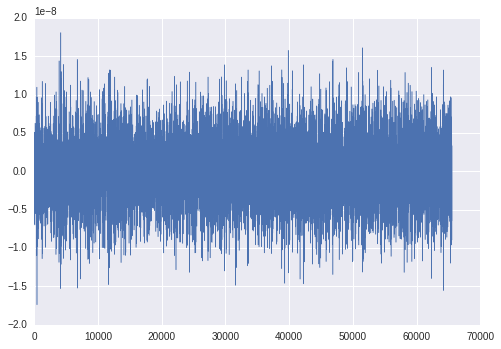

In [4]:
#Plot position
plt.plot(x,linewidth=0.5)

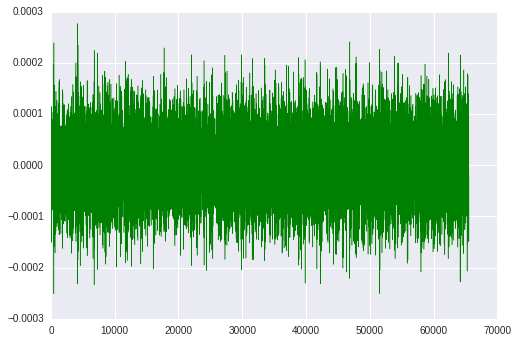

In [5]:
#Plot velocity
plt.plot(v,'g',linewidth=0.5)

In [6]:
#Stationary estimates
#Simulation parameters are m = 1ng and k = 225e-6 N/m
k_est_stat = k_B*T/(np.var(x))
m_est_stat = k_B*T/(np.var(v))
print k_est_stat*1e6
print m_est_stat*1e12

219.643336789
0.981241606258


In [7]:
#matrix sufficient statistics
T1_11 = np.sum(x[1:]**2)
T1_12 = np.sum(x[1:]*v[1:])
T1_21 = T1_12
T1_22 = np.sum(v[1:]**2)

T2_11 = np.sum(x[1:]*x[:-1])
T2_12 = np.sum(x[1:]*v[:-1])
T2_21 = np.sum(v[1:]*x[:-1])
T2_22 = np.sum(v[1:]*v[:-1])

T3_11 = np.sum(x[:-1]*x[:-1])
T3_12 = np.sum(x[:-1]*v[:-1])
T3_21 = T3_12
T3_22 = np.sum(v[:-1]*v[:-1])


T1 = np.asanyarray([[T1_11,T1_12],[T1_21,T1_22]])
T2 = np.asanyarray([[T2_11,T2_12],[T2_21,T2_22]])
T3 = np.asanyarray([[T3_11,T3_12],[T3_21,T3_22]])
T2

array([[  1.10386648e-12,   3.76173506e-09],
       [ -3.73935927e-09,   2.35983703e-04]])

In [8]:
#Bayesian estimate of Sigma matrix
invT3 = np.linalg.inv(T3)
Sigma_est = (1/N)*(T1 - (T2*invT3*np.transpose(T2)))
print Sigma_est

[[  8.72450318e-19   1.67674361e-16]
 [  1.67674361e-16   5.18441035e-10]]


In [9]:
#Bayesian estimate of exponential of drift (lambda) matrix

Lambda_exp =T2*invT3
print Lambda_exp

[[  9.74472358e-01  -1.48939285e-04]
 [  1.48053354e-04   9.30599637e-01]]


In [10]:
#Estimation of m and k from Sigma and Lambda using
#Method given in Appendix

coeffmat = np.matrix([[1-(Lambda_exp[0,0]**2),-Lambda_exp[0,1]**2],[-Lambda_exp[1,0]**2,1-(Lambda_exp[1,1]**2)]])
#RHS Matrix
invcoeffmat = np.linalg.inv(coeffmat) #inverse of RHS Matrix
sigvec = np.array([Sigma_est[0,0],Sigma_est[1,1]]) #RHS vector
cvec = np.dot(invcoeffmat,sigvec) #LHS vector (solution)

#The solution vector is [k_B*T/k, k_B*T/m]
#We estimate k and m as follows

k_est_inv = (k_B*T)/cvec[0,0] 
m_est_inv = (k_B*T)/cvec[0,1]

print k_est_inv*1e6
print m_est_inv*1e12

2.20709857882
0.981229304715


In [11]:
#Estimation of gamma using
#Method given in Appendix

gamma_est_inv = (Sigma_est[0,1]*(m_est_inv**2))/(k_B*T*(Lambda_exp[0,1]**2))
print gamma_est_inv

1.91678425905e-12


In [13]:
#Drift matrix from the relation \Lambda = exp(-\lambda*dt)

Lambda_exp2 = Lambda_exp*Lambda_exp
Lambda_exp2 = Lambda_exp2.transpose()
epsilon = np.matrix([[1,0],[0,-1]])
Eeps = Lambda_exp2*epsilon
c_Onsager = np.linalg.inv(np.eye(2) - epsilon*Eeps)
c_Onsager = np.dot(c_Onsager, Sigma_est)

print c_Onsager

[[  1.73087336e-17   1.64388093e-15]
 [  1.25144768e-15   3.86941586e-09]]


In [14]:
#Print c matrix obtained from result in appendix
print np.matrix([[cvec[0,0],0],[0,cvec[0,1]]])

[[  1.72026038e-15   0.00000000e+00]
 [  0.00000000e+00   3.86941586e-09]]


In [16]:
#Results with updated Onsager Casimir matrix

LambEps = Lambda_exp*epsilon
LambEps = LambEps.transpose()
c_OnsCas = np.linalg.inv(np.eye(2)-(LambEps*LambEps))
c_OnsCas = Sigma_est*c_OnsCas
print c_OnsCas

[[  1.74715244e-17   1.25144873e-15]
 [  5.04961539e-13   3.86941652e-09]]
